In [1]:
!ls "sample_data"

anscombe.json		      me.m4a		     README.md
california_housing_test.csv   mnist_test.csv
california_housing_train.csv  mnist_train_small.csv


In [2]:
!python -m pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pydub import AudioSegment
from pydub.utils import mediainfo
import scipy
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython import display
import IPython.display as ipd

## Reading file and preprocessing
---

In [5]:
# reading file from folder

src = "sample_data/me.m4a"
y, sr = librosa.load(src)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [6]:
ipd.Audio(y, rate=sr) 

In [7]:
# y-> is the audio sample
# sr -> is the sampling rate (no: samples / second)

y.shape, sr

((90788,), 22050)

In [8]:
# getting audio file info

info = mediainfo(src)
duration = float(info['duration']) # in seconds

def get_info():
  msg = f"""  file name          : {info['filename']}
  file size          : {float(info['size'])/1024} kb
  audio duration     : {info['duration']} Sec
  sample rate        : {info['sample_rate']} 
  no: audio channels : {info['channels']}"""
  
  print(msg)

In [9]:
get_info()

  file name          : sample_data/me.m4a
  file size          : 65.9150390625 kb
  audio duration     : 4.117000 Sec
  sample rate        : 48000 
  no: audio channels : 2


In [10]:
# normalizing 

samples = y/y.max()

In [11]:
# create x-axis timeline for refference in plot

timeline = np.linspace(0, duration, len(y))

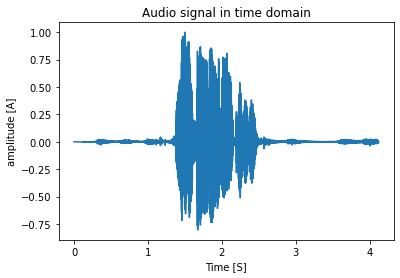

In [12]:
# plotting audio sample

plt.plot(timeline, samples)
plt.title("Audio signal in time domain")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

## VAD - Voice Activity Detection
---
* threshold based

In [13]:
# initializing variables

weight = 0.1 # weight or a adjustable parameter
v_window = int(0.01*len(samples)) # window size = here we take 1% of sample size.
vad_T = np.mean(samples**2) * weight
vad_T, v_window

(0.0015185132622718813, 907)

In [14]:
# voice activity detection

vad = np.zeros(shape=samples.shape)
ref_idx = []
for s_set in range(0, len(samples)-v_window, v_window):
      win_samples = samples[s_set:(s_set + v_window)]
      s_T = np.mean(win_samples**2)
      if s_T > vad_T:
        vad[s_set:(s_set + v_window)] = 1.0
        ref_idx.append(s_set)
      else:
        vad[s_set:(s_set + v_window)] = 0.0

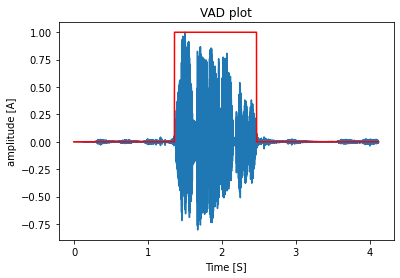

In [15]:
# plotting audio samples

plt.plot(timeline, samples)
plt.plot(timeline, vad, color='red')
plt.title("VAD plot")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

In [16]:
# cropping audio only across VAD timeline
new_samples = samples[min(ref_idx) : max(ref_idx)]
new_timeline = np.linspace(0, len(new_samples)/sr, len(new_samples))

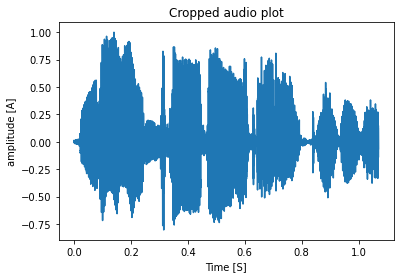

In [17]:
# plotting audio samples

plt.plot(new_timeline, new_samples)
plt.title("Cropped audio plot")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

In [18]:
ipd.Audio(new_samples, rate=sr) 

## pre-emphasis
---

In [19]:
# pre-emphasising audio signal

pre_emphasis = 0.97
emphasized_signal = np.append(new_samples[0], new_samples[1:] - pre_emphasis * new_samples[:-1])
emphasized_signal.shape

(23582,)

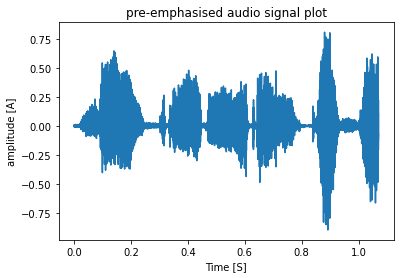

In [20]:
plt.plot(new_timeline, emphasized_signal)
plt.title("pre-emphasised audio signal plot")
plt.xlabel("Time [S]")
plt.ylabel("amplitude [A]")
plt.show()

In [21]:
ipd.Audio(emphasized_signal, rate=sr) 

## fast fourier transform (FFT) - (time domain to frequency domain)
---

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


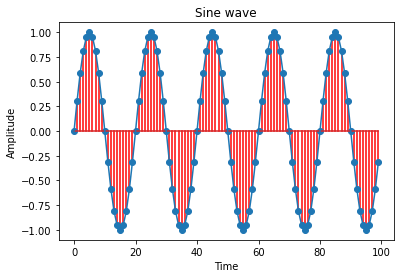

In [22]:
# basic sine wave

f = 5 #frequency
s = 100 #samples

x = np.arange(s)
y = np.sin(2*np.pi*f*(x/s))

plt.figure()
plt.stem(x, y,'r')
plt.plot(x, y)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Sine wave")
plt.show()

In [23]:
def plot_fft(signal, sr):
    fft_spectrum = np.fft.rfft(signal)
    freq = np.fft.rfftfreq(signal.size, d=1./sr)
    plt.plot(freq, np.abs(fft_spectrum), c='b')
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.title("FFT plot")
    plt.grid()
    plt.show()

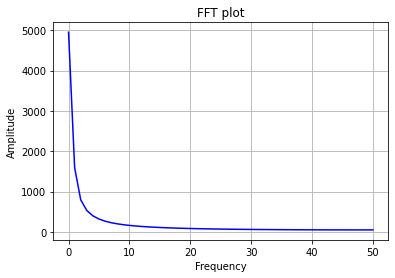

In [24]:
plot_fft(x, s)

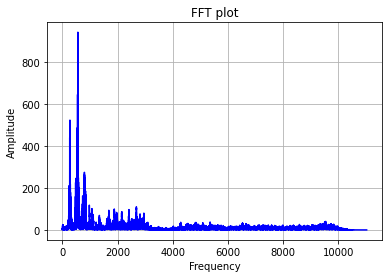

In [25]:
plot_fft(samples, sr)

## Sampling or Framing Audio signal
---

In [26]:
f_d = 0.0065
n_f = len(samples)
f_size = int(np.round(n_f * f_d))
print("frame duration: ", f_d, ", number of frames: ", n_f, ", frame size: ", f_size)

frame duration:  0.0065 , number of frames:  90788 , frame size:  590


In [27]:
frames = []

for i in range(0, (n_f-f_size), f_size):
  frame = samples[i:i+f_size]
  frames.append(frame)

frames = np.asarray(frames)
frames.shape

(153, 590)

In [28]:
from matplotlib.animation import FuncAnimation, PillowWriter

In [41]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_xlim(0,f_size)
    ax.set_ylim(-1,1)
    line, = ax.plot(frames[i, :], color = 'blue', lw=1)
    return line,
        
ani = FuncAnimation(fig, animate, interval=50, blit=True, repeat=True, frames=150)   
# SAVE  
ani.save("frame.gif", dpi=300, writer=PillowWriter(fps=20))

# live plot
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()

### Hann window function


In [30]:
def hanning(M):
    w = 0.54 - 0.46*np.cos(2*np.pi*np.arange(1, M+1)/(M-1))
    return w

In [31]:
wf = hanning(frames.shape[1])
wf.shape

(590,)

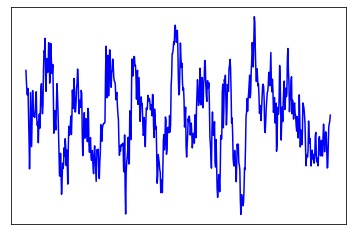

In [40]:
plt.plot(frames[126], c='b')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

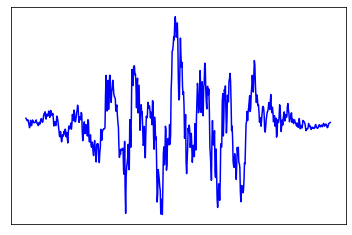

In [32]:
# plot example
fw = np.multiply(frames[126], wf)

plt.plot(fw, c='b')
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

In [33]:
# appliying hanning to all frames
frame_W = []
for f in frames:
    frame_W.append(np.multiply(wf, f))
frame_W = np.array(frame_W)
frame_W.shape

(153, 590)

In [42]:
fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    ax.set_xlim(0,f_size)
    ax.set_ylim(-1,1)
    line, = ax.plot(frame_W[i, :], color = 'blue', lw=1)
    return line,
        
ani = FuncAnimation(fig, animate, interval=50, blit=True, repeat=True, frames=150)    
ani.save("windows.gif", dpi=300, writer=PillowWriter(fps=20))

# live plot
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()

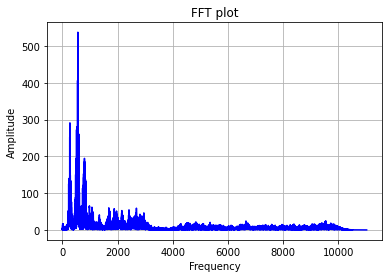

In [35]:
plot_fft(frame_W.ravel(), sr)

## spectrum plot
---

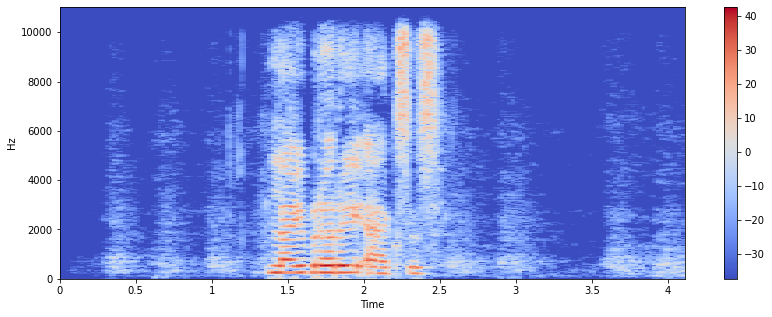

In [36]:
#display Spectrogram
X = librosa.stft(frame_W.ravel())
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## MFCC - Mel-Frequency Cepstral Coefficients
---
* feature extraction.

(20, 177)


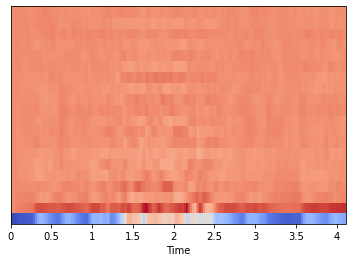

In [38]:
mfccs = librosa.feature.mfcc(frame_W.ravel(), sr=sr)
print(mfccs.shape)
#Displaying  the MFCCs:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

* re-generate audio signal from MFCC

In [39]:
wav = librosa.feature.inverse.mfcc_to_audio(mfccs)

ipd.Audio(wav, rate=sr)

In [ ]:
# END